Revenue Prediction
==================
In this project the goal is to predict movies revenue using their features. revenue is given by ( box_office - budget ) so the main goal is to predict box office. 

1. Prepare and preprocess the given data. 

2. After exploring data find, select and especially create new features. ignore others.

3. Prepare features to feed the model. 

4. Select and try different models.

5. Document and report each step using relative plots and a brief explanation. finally report the best suited model and justify why did it performed well.



- Keep in mind that in this task accuracy itself only has only part of score.

- Hint: to create new features you can use credit attributes. Think of it this way, what affects box office?  

**Tools** 

importing useful tools and libraries. you may use any other library as well.

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Modelling
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from collections import Counter
from scipy.stats import randint
from wordcloud import WordCloud

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import plotly.express as px

import ast

In [271]:
np.random.seed(101)

In [272]:
# Your project struct must look like this,


# |── Name_SID.zip
# │   ├── data
# │   │       ├── rotten_tomatoes_5000_movies.csv
# │   │       ├── rotten_tomatoes_5000_movies.csv
# │   ├── *.ipynb
# │   ├── document.pdf

df_movies = pd.read_csv(r"data/rotten_tomatoes_5000_movies.csv")
df_credit = pd.read_csv(r"data/rotten_tomatoes_5000_credits.csv")


In [201]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rt_production_budget     4803 non-null   int64  
 1   rt_genres                4803 non-null   object 
 2   rt_website               1712 non-null   object 
 3   rt_movie_id              4803 non-null   int64  
 4   rt_keywords              4803 non-null   object 
 5   rt_original_language     4803 non-null   object 
 6   rt_original_title        4803 non-null   object 
 7   rt_synopsis              4800 non-null   object 
 8   rt_audience_score        4803 non-null   float64
 9   rt_studios               4803 non-null   object 
 10  rt_production_countries  4803 non-null   object 
 11  rt_release_date          4802 non-null   object 
 12  rt_box_office            4803 non-null   int64  
 13  rt_runtime               4801 non-null   float64
 14  rt_languages            

In [202]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rt_movie_id  4803 non-null   int64 
 1   rt_title     4803 non-null   object
 2   rt_actors    4803 non-null   object
 3   rt_staff     4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [203]:
df_credit.head()

,rt_movie_id,rt_title,rt_actors,rt_staff
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [204]:
df_movies.head()

,rt_production_budget,rt_genres,rt_website,rt_movie_id,rt_keywords,rt_original_language,rt_original_title,rt_synopsis,rt_audience_score,rt_studios,rt_production_countries,rt_release_date,rt_box_office,rt_runtime,rt_languages,rt_release_status,rt_tagline,rt_title,rt_critics_score,rt_review_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124







# First Part: EDA

In [273]:
# Helper function to parse the 'rt_actors' column
def parse_list_column(column):
    """Convert string representation of list to actual list."""
    return column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

def extract_dict_field(column, field_name):
    """Extract a specific field from a dictionary within a column."""
    return column.apply(lambda x: x[field_name] if isinstance(x, dict) else None)

# Create a temporary DataFrame for processing
temp_df = df_movies.copy()



### Calculate the number of possible genres

In [274]:
# Safely convert the genre column
df_movies_genres = temp_df['rt_genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else []
)

# Expand the genres
all_genres = df_movies_genres.explode().dropna()

# Extract genre names
unique_genres = all_genres.apply(lambda x: x['name'] if isinstance(x, dict) else None).dropna().unique()

# Count unique genres
num_genres = len(unique_genres)

print(f"The number of unique genres is: {num_genres}")


The number of unique genres is: 20


### 1) What is the average earning of each movie genre?

In [275]:
df_genres_expanded = df_movies.copy()
df_genres_expanded['rt_genres'] = parse_list_column(df_genres_expanded['rt_genres'])

# Expand genres into separate rows
genres_expanded = df_genres_expanded.explode('rt_genres')
genres_expanded['genre_name'] = extract_dict_field(genres_expanded['rt_genres'], 'name')
genres_expanded = genres_expanded.dropna(subset=['genre_name'])

# Calculate average production budget by genre
average_budget_by_genre = genres_expanded.groupby('genre_name')['rt_production_budget'].mean().reset_index()
sorted_budget_by_genre = average_budget_by_genre.sort_values(by='rt_production_budget', ascending=False)

Plot (Plotly)

In [276]:
fig = px.bar(
    sorted_budget_by_genre,
    x='genre_name',
    y='rt_production_budget',
    title='Average Production Budget by Genre',
    labels={'genre_name': 'Genre', 'rt_production_budget': 'Production Budget (USD)'},
    text='rt_production_budget'
)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(xaxis_title='Genre', yaxis_title='Average Production Budget (USD)', title_x=0.5)
fig.show()

### 2) What is the share of each country in the total cost for each genre? (List the top 5 most expensive genres by country.)

In [282]:
temp_df = df_movies.copy()

# Parse genres and countries
temp_df['rt_genres'] = parse_list_column(temp_df['rt_genres'])
temp_df['rt_production_countries'] = parse_list_column(temp_df['rt_production_countries'])

# Expand genres and countries into separate rows
countries_expanded = temp_df.explode('rt_genres').explode('rt_production_countries')

# Extract names
countries_expanded['genre_name'] = extract_dict_field(countries_expanded['rt_genres'], 'name')
countries_expanded['country_name'] = extract_dict_field(countries_expanded['rt_production_countries'], 'name')

# Drop missing values
valid_data = countries_expanded.dropna(subset=['genre_name', 'country_name'])

# Calculate total budget per country-genre pair
country_genre_budget = valid_data.groupby(['country_name', 'genre_name'])['rt_production_budget'].sum().reset_index()

# Calculate total budget per genre
total_budget_by_genre = country_genre_budget.groupby('genre_name')['rt_production_budget'].sum().reset_index()
total_budget_by_genre.rename(columns={'rt_production_budget': 'total_genre_budget'}, inplace=True)

# Merge to compute the share
country_genre_budget = country_genre_budget.merge(total_budget_by_genre, on='genre_name', how='left')
country_genre_budget['share'] = (country_genre_budget['rt_production_budget'] / country_genre_budget['total_genre_budget']) * 100

# Select the top 5 most expensive genres
top_5_expensive_genres = total_budget_by_genre.nlargest(5, 'total_genre_budget')['genre_name']

# Filter dataset for only these genres
top_5_genres_per_country = country_genre_budget[country_genre_budget['genre_name'].isin(top_5_expensive_genres)]

# Find the top 10 countries with the highest total budget
top_10_countries = country_genre_budget.groupby('country_name')['rt_production_budget'].sum().nlargest(10).index

# Replace countries not in the top 10 with "Other"
top_5_genres_per_country['country_name'] = top_5_genres_per_country['country_name'].apply(
    lambda x: x if x in top_10_countries else 'Other'
)

# Aggregate the "Other" category
top_5_genres_per_country = top_5_genres_per_country.groupby(['country_name', 'genre_name'])[['rt_production_budget', 'share']].sum().reset_index()


C:\Users\hsham\AppData\Local\Temp\ipykernel_8504\3089020115.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Plot

In [278]:
fig = px.bar(
    top_5_genres_per_country,
    x='genre_name',
    y='share',
    color='country_name',
    title='Share of Each Country in Total Cost for Top 5 Most Expensive Genres',
    labels={'genre_name': 'Genre', 'share': 'Share (%)', 'country_name': 'Country'},
    text='share'
)
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(xaxis_title='Genre', yaxis_title='Share in Total Cost (%)', title_x=0.5)
fig.show()

In [279]:
# Generate pie charts for each genre
for genre in top_5_expensive_genres:
    genre_data = top_5_genres_per_country[top_5_genres_per_country['genre_name'] == genre]
    
    fig_pie = px.pie(
        genre_data,
        names='country_name',
        values='share',
        title=f'Share of Countries in {genre} Genre Production Budget',
        labels={'country_name': 'Country', 'share': 'Share (%)'}
    )
    fig_pie.show()

### 3) Compare the number of movies produced in 3 genres over the past 10 years.

In [289]:
temp_df['rt_release_date'] = pd.to_datetime(temp_df['rt_release_date'], errors='coerce')
temp_df['release_year'] = temp_df['rt_release_date'].dt.year

last_10_years = temp_df[temp_df['release_year'].between(2006, 2016)]
genres_expanded = last_10_years.explode('rt_genres')
genres_expanded['genre_name'] = extract_dict_field(genres_expanded['rt_genres'], 'name')

selected_genres = ['Animation', 'Science Fiction', 'Action']
filtered_genres = genres_expanded[genres_expanded['genre_name'].isin(selected_genres)]
genre_counts = filtered_genres.groupby(['release_year', 'genre_name']).size().reset_index(name='movie_count')

Plot

In [291]:
fig = px.line(
    genre_counts,
    x='release_year',
    y='movie_count',
    color='genre_name',
    title='Number of Movies Produced in Selected Genres (2006-2016)',
    labels={'release_year': 'Year', 'movie_count': 'Number of Movies', 'genre_name': 'Genre'}
)
fig.update_layout(xaxis=dict(tickmode='linear', dtick=1), yaxis_title='Number of Movies', xaxis_title='Year', title_x=0.5)
fig.show()

### 4) On average, which country produces the longest and shortest movies?

In [292]:
temp_df = df_movies.copy()

# Convert the 'rt_production_countries' column to a list of dictionaries
temp_df['rt_production_countries'] = temp_df['rt_production_countries'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

# Expand the 'rt_production_countries' column into separate rows
countries_expanded = temp_df.explode('rt_production_countries')

# Extract country names from the dictionary
countries_expanded['country_name'] = countries_expanded['rt_production_countries'].apply(
    lambda x: x['name'] if isinstance(x, dict) else None
)

# Drop rows with invalid or missing data
countries_expanded = countries_expanded.dropna(subset=['country_name', 'rt_runtime'])

# Group by country and calculate the average runtime
average_runtime_by_country = countries_expanded.groupby('country_name')['rt_runtime'].mean().reset_index()

# Find the country with the longest and shortest average runtime
longest_runtime_country = average_runtime_by_country.loc[average_runtime_by_country['rt_runtime'].idxmax()]
shortest_runtime_country = average_runtime_by_country.loc[average_runtime_by_country['rt_runtime'].idxmin()]


In [293]:
print(f"The country with the longest movies on average is: {longest_runtime_country['country_name']} ({longest_runtime_country['rt_runtime']:.2f} minutes).")
print(f"The country with the shortest movies on average is: {shortest_runtime_country['country_name']} ({shortest_runtime_country['rt_runtime']:.2f} minutes).")

The country with the longest movies on average is: Libyan Arab Jamahiriya (173.00 minutes).
The country with the shortest movies on average is: Kenya (60.00 minutes).


In [294]:
fig = px.box(
    countries_expanded,
    x='country_name',
    y='rt_runtime',
    title='Distribution of Movie Runtimes by Country',
    labels={'rt_runtime': 'Runtime (minutes)', 'country_name': 'Country'},
    points='all'
)
fig.update_layout(xaxis_title='Country', yaxis_title='Runtime (minutes)', title_x=0.5)
fig.show()

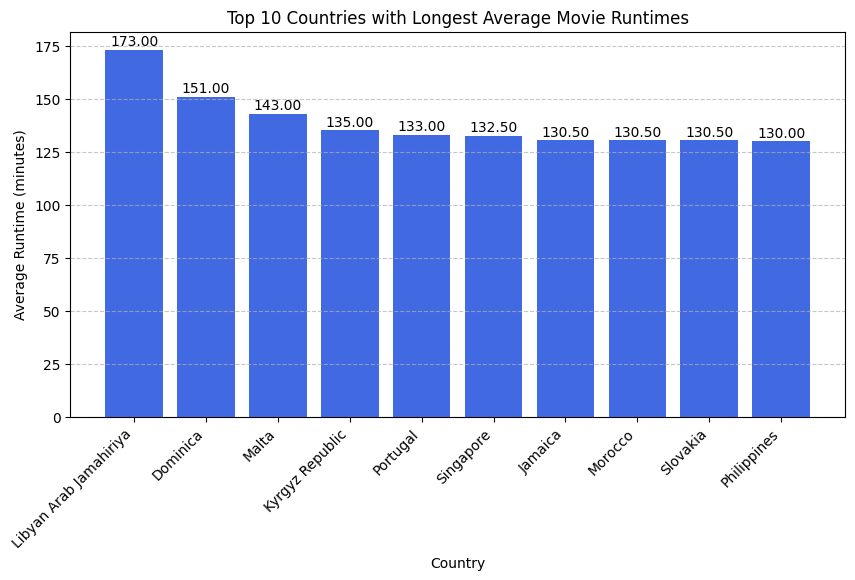

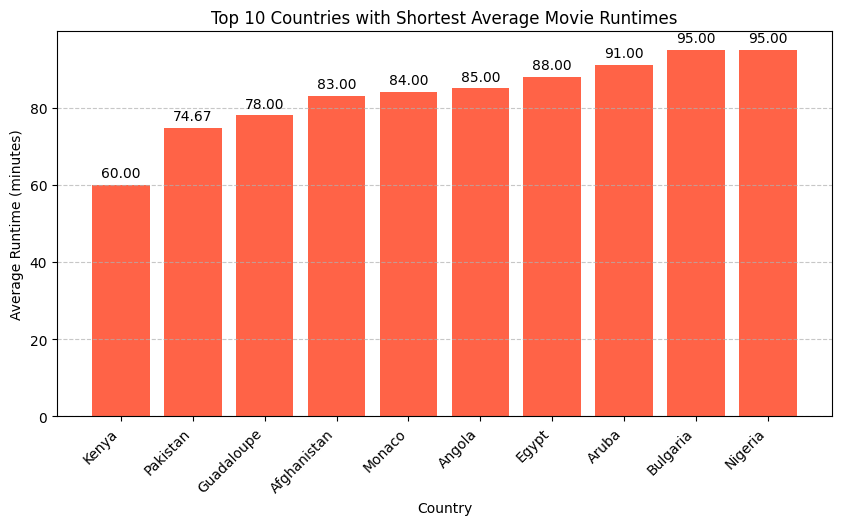

In [168]:
# Sort by runtime to get top 10 longest and shortest countries
top_10_longest = average_runtime_by_country.nlargest(10, 'rt_runtime')
top_10_shortest = average_runtime_by_country.nsmallest(10, 'rt_runtime')

# Plot for top 10 longest runtimes
plt.figure(figsize=(10, 5))
plt.bar(top_10_longest['country_name'], top_10_longest['rt_runtime'], color='royalblue')
plt.xlabel('Country')
plt.ylabel('Average Runtime (minutes)')
plt.title('Top 10 Countries with Longest Average Movie Runtimes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show runtime values on bars
for i, v in enumerate(top_10_longest['rt_runtime']):
    plt.text(i, v + 2, f"{v:.2f}", ha='center', fontsize=10)

plt.show()

# Plot for top 10 shortest runtimes
plt.figure(figsize=(10, 5))
plt.bar(top_10_shortest['country_name'], top_10_shortest['rt_runtime'], color='tomato')
plt.xlabel('Country')
plt.ylabel('Average Runtime (minutes)')
plt.title('Top 10 Countries with Shortest Average Movie Runtimes')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show runtime values on bars
for i, v in enumerate(top_10_shortest['rt_runtime']):
    plt.text(i, v + 2, f"{v:.2f}", ha='center', fontsize=10)

plt.show()


### 5) Apart from English, what are the most frequently used languages in movies?

In [299]:
# Create a temporary DataFrame for processing
temp_df = df_movies.copy()

# Parse the 'rt_languages' column
temp_df['rt_languages'] = parse_list_column(temp_df['rt_languages'])

# Expand the languages into separate rows
languages_expanded = temp_df.explode('rt_languages')

# Extract the language names from the dictionaries
languages_expanded['language_name'] = languages_expanded['rt_languages'].apply(
    lambda x: x['name'] if isinstance(x, dict) else None
)

# Drop rows with missing or invalid languages
languages_expanded = languages_expanded.dropna(subset=['language_name'])

# Exclude English
non_english_languages = languages_expanded[languages_expanded['language_name'] != 'English']

# Count the occurrences of each language
language_counts = non_english_languages['language_name'].value_counts().reset_index()
language_counts.columns = ['language_name', 'movie_count']


In [300]:
# Display the top 10 most frequently used languages
print("Top 10 Most Frequently Used Languages (Excluding English):")
print(language_counts.head(9))

Top 10 Most Frequently Used Languages (Excluding English):
  language_name  movie_count
0      Français          437
1       Español          351
2       Deutsch          262
3      Italiano          188
4       Pусский          185
5           普通话          107
6           日本語           97
7     Português           68
8       العربية           67


Plot

In [304]:
# Plot a pie chart for the top 9 languages
fig = px.pie(
    language_counts.head(9), 
    values='movie_count', 
    names='language_name',
    title='Top 9 Most Frequently Used Languages in Movies (Excluding English)',
    hole=0.4  # To create a donut chart (optional)
)

# Show the chart
fig.show()

### 6) In the past 10 years, what has been the average annual cost of the film industry in the United States? (with a yearly breakdown) HANDLE NAN

In [305]:
countries_expanded['rt_release_date'] = pd.to_datetime(countries_expanded['rt_release_date'], errors='coerce')
# Extract only year
countries_expanded['release_year'] = countries_expanded['rt_release_date'].dt.year

# Filter U.S. movies
us_movies = countries_expanded[countries_expanded['country_name'] == 'United States of America']

# Filter last 10 years
current_year = pd.Timestamp.now().year
us_movies = us_movies[us_movies['release_year'].between(countries_expanded['release_year'].max() - 10, current_year)]

# Compute yearly average production budget
yearly_cost = us_movies.groupby('release_year')['rt_production_budget'].mean().reset_index()
yearly_cost.fillna(0, inplace=True)

Line Chart

In [306]:
fig = px.line(
    yearly_cost,
    x='release_year',
    y='rt_production_budget',
    title='Average Annual Cost of the Film Industry in the U.S. (Last 10 Years)',
    labels={'release_year': 'Year', 'rt_production_budget': 'Average Production Budget (USD)'}
)

fig.update_traces(mode="lines+markers")

# Automatically determine y-axis tick interval based on the data range
y_min = yearly_cost['rt_production_budget'].min()
y_max = yearly_cost['rt_production_budget'].max()
y_interval = (y_max - y_min) / 10  # Reduce the interval for finer tick spacing

fig.update_layout(
    xaxis=dict(tickmode='linear', dtick=1),
    yaxis=dict(tickmode='linear', dtick=y_interval),  # Adjust y-axis tick spacing
    yaxis_title='Production Budget (USD)', 
    xaxis_title='Year', 
    title_x=0.5
)

fig.show()

### 7) Compare the cost trend for other countries over the past 10 years (excluding the U.S.).  BUGGY

In [315]:

# Create a copy of the original dataframe
temp_df = df_movies.copy()

# Convert release date to datetime
temp_df['rt_release_date'] = pd.to_datetime(temp_df['rt_release_date'], errors='coerce')

# Drop rows with invalid release dates
temp_df = temp_df.dropna(subset=['rt_release_date'])

# Extract release year
temp_df['release_year'] = temp_df['rt_release_date'].dt.year

# Parse production countries
temp_df['rt_production_countries'] = parse_list_column(temp_df['rt_production_countries'])

# Expand country column (flatten the list of countries)
countries_expanded = temp_df.explode('rt_production_countries')

# Extract country names from the dictionaries
countries_expanded['country_name'] = countries_expanded['rt_production_countries'].apply(
    lambda x: x['name'] if isinstance(x, dict) else None
)

# Remove U.S. movies (filter out 'United States of America')
non_us_movies = countries_expanded[countries_expanded['country_name'] != 'United States of America']

# Define the time span for the last 10 years
max_year = non_us_movies['release_year'].max()
time_span = 10
non_us_movies_last_10_years = non_us_movies[non_us_movies['release_year'].between(max_year - time_span, max_year)]

# Calculate the average production budget for non-US movies over the last 10 years
yearly_avg_budget = (
    non_us_movies_last_10_years.groupby('release_year')['rt_production_budget']
    .mean()
    .reset_index()
    .rename(columns={'rt_production_budget': 'average_production_budget'})
)


Plot

In [316]:
fig = px.line(
    yearly_cost_non_us,
    x='release_year',
    y='average_production_budget',
    color='country_name',
    title=f'Average Annual Cost of the Film Industry (Excluding U.S.) Over the Past {time_span} Years',
    labels={'release_year': 'Year', 'average_production_budget': 'Average Production Budget (USD)', 'country_name': 'Country'}
)

fig.update_traces(mode="lines+markers")  
fig.update_layout(
    xaxis=dict(tickmode='linear', dtick=1),  # Show yearly ticks
    yaxis_title='Average Production Budget (USD)',
    xaxis_title='Year',
    title_x=0.5
)

fig.show()


In [317]:
temp_df = df_movies.copy()
temp_df['rt_release_date'] = pd.to_datetime(temp_df['rt_release_date'], errors='coerce')
temp_df = temp_df.dropna(subset=['rt_release_date'])  # Drop rows with invalid release dates
temp_df['release_year'] = temp_df['rt_release_date'].dt.year

# Parse country data
temp_df['rt_production_countries'] = parse_list_column(temp_df['rt_production_countries'])
countries_expanded = temp_df.explode('rt_production_countries')

# Extract country names
countries_expanded['country_name'] = countries_expanded['rt_production_countries'].apply(
    lambda x: x['name'] if isinstance(x, dict) else None
)

# Exclude US movies
non_us_movies = countries_expanded[countries_expanded['country_name'] != 'United States of America']

# Define current year and time span
# current_year = pd.Timestamp.now().year
time_span = 10

# Filter movies released in the past 10 years
non_us_movies_last_10_years = non_us_movies[
    non_us_movies['release_year'].between(non_us_movies['release_year'].max() - 1 - time_span, non_us_movies['release_year'].max() - 1)
]

# Group by release year and sum the production budgets
yearly_cumulative_budget_non_us = (
    non_us_movies_last_10_years.groupby('release_year')['rt_production_budget']
    .sum()
    .reset_index()
    .rename(columns={'rt_production_budget': 'cumulative_production_budget'})
)

# Ensure budgets are non-negative (optional safety check)
yearly_cumulative_budget_non_us['cumulative_production_budget'] = yearly_cumulative_budget_non_us['cumulative_production_budget'].clip(lower=0)

print(yearly_cumulative_budget_non_us)


    release_year  cumulative_production_budget
0           2006                    5582430087
1           2007                    3589285033
2           2008                    5574800699
3           2009                    4998233162
4           2010                    2968290111
5           2011                    3445382431
6           2012                    2798280962
7           2013                    3329725759
8           2014                    4440803210
9           2015                    3487122364
10          2016                    3129230000


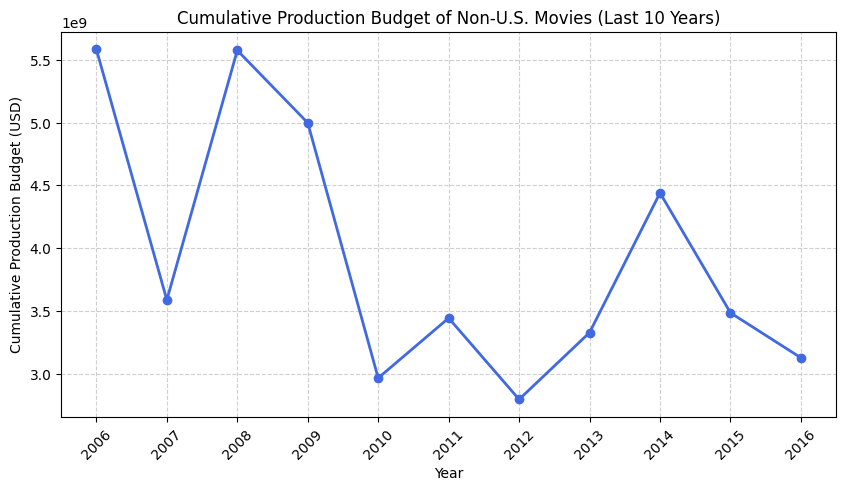

In [318]:

# Plot cumulative production budget over the years
plt.figure(figsize=(10, 5))
plt.plot(
    yearly_cumulative_budget_non_us['release_year'],
    yearly_cumulative_budget_non_us['cumulative_production_budget'],
    marker='o',
    linestyle='-',
    color='royalblue',
    linewidth=2
)

# Labels and title
plt.xlabel('Year')
plt.ylabel('Cumulative Production Budget (USD)')
plt.title('Cumulative Production Budget of Non-U.S. Movies (Last 10 Years)')
plt.xticks(yearly_cumulative_budget_non_us['release_year'], rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()


### 8) What movies has Johnny Depp acted in?

In [181]:
temp_df = df_credit.copy()

temp_df['rt_actors'] = parse_list_column(temp_df['rt_actors'])
johnny_depp_movies = temp_df[temp_df['rt_actors'].apply(
    lambda actors: any(actor['name'] == 'Johnny Depp' for actor in actors if isinstance(actor, dict))
)]

johnny_depp_movies = johnny_depp_movies[['rt_title', 'rt_movie_id']]
print("Movies Johnny Depp has acted in:")
print(johnny_depp_movies)


Movies Johnny Depp has acted in:
                                               rt_title  rt_movie_id
1              Pirates of the Caribbean: At World's End          285
12           Pirates of the Caribbean: Dead Man's Chest           58
13                                      The Lone Ranger        57201
17          Pirates of the Caribbean: On Stranger Tides         1865
32                                  Alice in Wonderland        12155
105                     Alice Through the Looking Glass       241259
117                   Charlie and the Chocolate Factory          118
133                                        Dark Shadows        62213
178                                               Rango        44896
199   Pirates of the Caribbean: The Curse of the Bla...           22
280                                      Public Enemies        11322
295                                         The Tourist        37710
333                                       Transcendence       157353
4

Plot

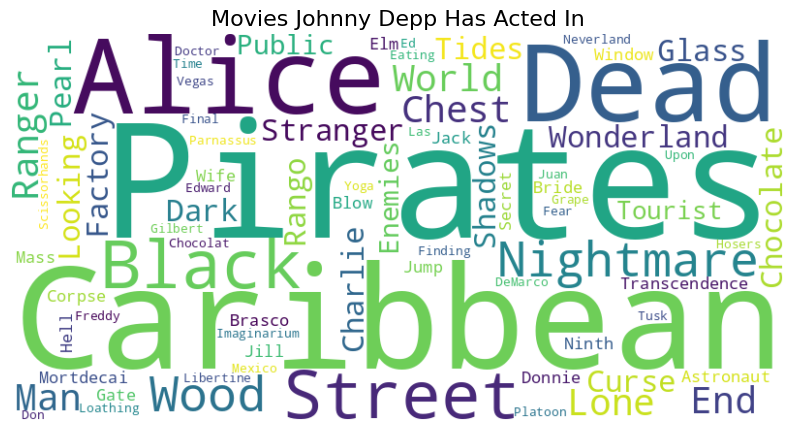

In [182]:
movie_titles = " ".join(johnny_depp_movies['rt_title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(movie_titles)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Movies Johnny Depp Has Acted In", fontsize=16)
plt.show()


### 9) On average, what percentage of lead roles (top 5 in movies) are played by men and what percentage by women?

In [183]:
temp_df = df_credit.copy()

temp_df['parsed_actors'] = temp_df['rt_actors'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

actors_expanded = temp_df.explode('parsed_actors')
actors_expanded['gender'] = actors_expanded['parsed_actors'].apply(
    lambda x: x['gender'] if isinstance(x, dict) else None
)
actors_expanded['order'] = actors_expanded['parsed_actors'].apply(
    lambda x: x['order'] if isinstance(x, dict) else None
)

# (top 5 by order)
lead_roles = actors_expanded[actors_expanded['order'] < 5]

gender_distribution = lead_roles['gender'].value_counts(normalize=True) * 100

gender_labels = {1: 'Female', 2: 'Male', 0: 'Unknown'}
gender_distribution.index = gender_distribution.index.map(gender_labels)

In [184]:
# the results
print("Average Percentage of Lead Roles by Gender:")
print(gender_distribution)

Average Percentage of Lead Roles by Gender:
gender
Male       58.909232
Female     31.300499
Unknown     9.790270
Name: proportion, dtype: float64


Plot

In [185]:
fig = px.pie(
    names=gender_distribution.index,
    values=gender_distribution.values,
    title='Average Percentage of Lead Roles by Gender',
    labels={'value': 'Percentage', 'index': 'Gender'}
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

Each Role Separately:

In [186]:
# Create a temporary copy of the dataset
temp_df = df_credit.copy()

# Parse the actors list into proper format
temp_df['parsed_actors'] = temp_df['rt_actors'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

# Expand the actors list
actors_expanded = temp_df.explode('parsed_actors')

# Extract gender and order from the parsed actor data
actors_expanded['gender'] = actors_expanded['parsed_actors'].apply(
    lambda x: x['gender'] if isinstance(x, dict) else None
)
actors_expanded['order'] = actors_expanded['parsed_actors'].apply(
    lambda x: x['order'] if isinstance(x, dict) else None
)

# Filter out the top 5 by order (lead roles)
lead_roles = actors_expanded[actors_expanded['order'] < 5]

# Gender labels for readability
gender_labels = {1: 'Female', 2: 'Male', 0: 'Unknown'}
lead_roles['gender'] = lead_roles['gender'].map(gender_labels)

# Find the percentage gender distribution for each order (e.g., order 1, order 2)
gender_distribution_by_order = lead_roles.groupby('order')['gender'].value_counts(normalize=True) * 100


C:\Users\hsham\AppData\Local\Temp\ipykernel_8504\3515048566.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Plot

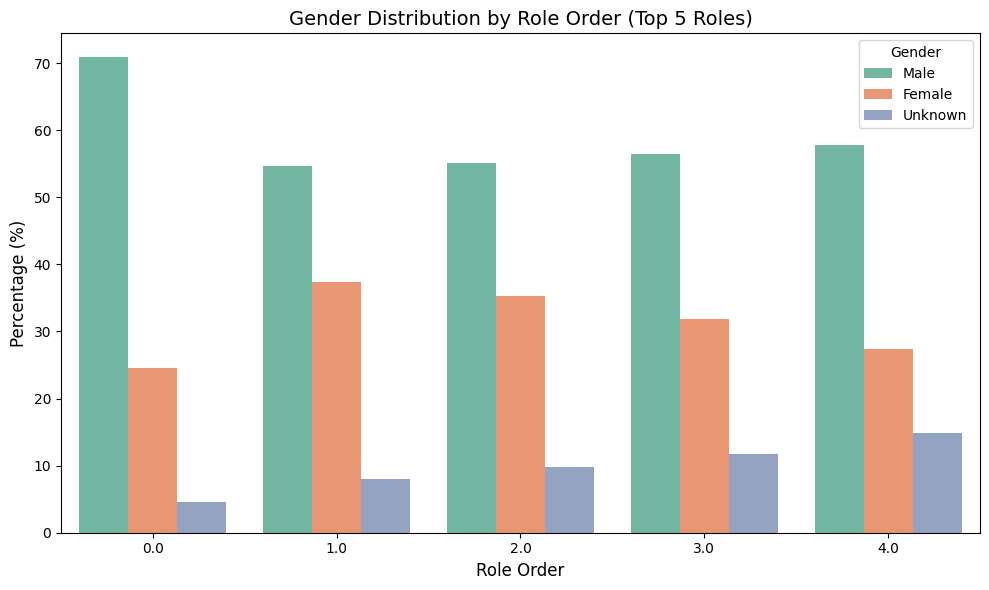

In [187]:
# Gender distribution by role order
gender_distribution_by_order = lead_roles.groupby('order')['gender'].value_counts(normalize=True) * 100

# Reset the index for easier plotting
gender_distribution_by_order = gender_distribution_by_order.reset_index(name='percentage')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=gender_distribution_by_order,
    x='order', 
    y='percentage', 
    hue='gender', 
    palette='Set2'
)

# Title and labels
plt.title('Gender Distribution by Role Order (Top 5 Roles)', fontsize=14)
plt.xlabel('Role Order', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Gender', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

### 11) What are the most popular genres of movies in the past 10 years? (Once based on the number of reviews and once based on the critics' scores.) (SHOULD BE RECHECKED)

In [188]:
temp_df = df_movies.copy()

temp_df['rt_genres'] = temp_df['rt_genres'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)

genres_expanded = temp_df.explode('rt_genres')

genres_expanded['genre_name'] = genres_expanded['rt_genres'].apply(
    lambda x: x['name'] if isinstance(x, dict) else None
)

genres_expanded['release_year'] = pd.to_datetime(genres_expanded['rt_release_date'], errors='coerce').dt.year
genres_expanded = genres_expanded[genres_expanded['release_year'].between(genres_expanded['release_year'].max() - 11, genres_expanded['release_year'].max() - 1)]

reviews_popularity = genres_expanded.groupby('genre_name')['rt_review_count'].sum().reset_index()
reviews_popularity = reviews_popularity.sort_values(by='rt_review_count', ascending=False)

critics_popularity = genres_expanded.groupby('genre_name')['rt_critics_score'].mean().reset_index()
critics_popularity = critics_popularity.sort_values(by='rt_critics_score', ascending=False)


Plot 1

In [189]:
fig_reviews = px.bar(
    reviews_popularity,
    x='genre_name',
    y='rt_review_count',
    title='Most Popular Genres (Based on Number of Reviews - Past 10 Years)',
    labels={'genre_name': 'Genre', 'rt_review_count': 'Number of Reviews'},
    text='rt_review_count'
)
fig_reviews.update_traces(textposition='outside')
fig_reviews.update_layout(
    xaxis_title='Genre',
    yaxis_title='Number of Reviews',
    title_x=0.5
)

fig_reviews.show()

Plot 2

In [190]:
# Plot 2: Popular genres based on critics' scores
fig_critics = px.bar(
    critics_popularity,
    x='genre_name',
    y='rt_critics_score',
    title='Most Popular Genres (Based on Critics\' Scores - Past 10 Years)',
    labels={'genre_name': 'Genre', 'rt_critics_score': 'Average Critics\' Score'},
    text='rt_critics_score'
)

# Update trace to format text to show 2 decimal places
fig_critics.update_traces(
    texttemplate='%{text:.2f}',  # Format text to 2 decimal places
    textposition='outside'
)

# Update layout
fig_critics.update_layout(
    xaxis_title='Genre',
    yaxis_title='Average Critics\' Score',
    title_x=0.5
)

# Show the plot
fig_critics.show()


In [191]:
# Group by release year and genre, calculating the sum of reviews and average critics score
reviews_yearly = genres_expanded.groupby(['release_year', 'genre_name'])['rt_review_count'].sum().reset_index()
critics_yearly = genres_expanded.groupby(['release_year', 'genre_name'])['rt_critics_score'].mean().reset_index()

In [192]:
# Plot 1: Most Popular Genres Based on Number of Reviews (Per Year)
fig_reviews = px.bar(
    reviews_yearly,
    x='release_year',
    y='rt_review_count',
    color='genre_name',
    title='Most Popular Genres Based on Number of Reviews (Per Year)',
    labels={'release_year': 'Year', 'rt_review_count': 'Number of Reviews'},
    barmode='group'
)

fig_reviews.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Reviews',
    title_x=0.5,
    xaxis=dict(tickmode='linear', dtick=1)
)

# Show plot
fig_reviews.show()

In [193]:
fig_critics = px.bar(
    critics_yearly,
    x='release_year',
    y='rt_critics_score',
    color='genre_name',
    title='Most Popular Genres Based on Critics\' Scores (Per Year)',
    labels={'release_year': 'Year', 'rt_critics_score': 'Average Critics\' Score'},
    barmode='group'
)

fig_critics.update_layout(
    xaxis_title='Year',
    yaxis_title='Average Critics\' Score',
    title_x=0.5,
    xaxis=dict(tickmode='linear', dtick=1)
)

# Show plot
fig_critics.show()

# Second Part: Movie Revenue Prediction

## Preprocessing and Creating New Features

### Feature Engineering

In [125]:
# Parse genres, actors, and directors safely
def parse_genres(genres_str):
    try:
        genres = ast.literal_eval(genres_str)
        return [genre['name'] for genre in genres]
    except:
        return []

def parse_actors(actors_str):
    try:
        actors = ast.literal_eval(actors_str)
        return [actor['name'] for actor in actors]
    except:
        return []

def parse_directors(staff_str):
    try:
        staff = ast.literal_eval(staff_str)
        return [staff_member['name'] for staff_member in staff if staff_member['job'] == 'Director']
    except:
        return []

In [126]:
# Merge datasets
df = pd.merge(df_movies, df_credit, on='rt_movie_id', how='left')
df = df[df['rt_box_office'] != 0]  # Remove rows with zero box office

In [127]:
# Parse columns
df['parsed_genres'] = df['rt_genres'].apply(parse_genres)
df['parsed_actors'] = df['rt_actors'].apply(parse_actors)
df['parsed_directors'] = df['rt_staff'].apply(parse_directors)

In [128]:
# Create genre combinations as a single feature
df['genre_combination'] = df['parsed_genres'].apply(lambda x: ', '.join(sorted(x)) if x else '')

In [129]:
# Famous actors and directors
all_actors = [actor for actors_list in df['parsed_actors'] for actor in actors_list]
actor_counts = Counter(all_actors)
top_actors = [actor for actor, _ in actor_counts.most_common(15)]

all_directors = [director for directors_list in df['parsed_directors'] for director in directors_list]
director_counts = Counter(all_directors)
top_directors = [director for director, _ in director_counts.most_common(8)]

In [130]:
df['num_famous_actors'] = df['parsed_actors'].apply(lambda x: sum(actor in top_actors for actor in x))
df['num_famous_directors'] = df['parsed_directors'].apply(lambda x: sum(director in top_directors for director in x))

In [131]:
# Create derived features
df['log_budget'] = np.log1p(df['rt_production_budget'])
df['log_runtime'] = np.log1p(df['rt_runtime'])
df['budget_per_minute'] = df['rt_production_budget'] / df['rt_runtime']
df['release_year'] = pd.to_datetime(df['rt_release_date']).dt.year
df['release_month'] = pd.to_datetime(df['rt_release_date']).dt.month
df['age_of_movie'] = 2025 - df['release_year']
df['decade'] = (df['release_year'] // 10) * 10

In [132]:
# Interaction features
df['critic_audience_interaction'] = df['rt_critics_score'] * df['rt_audience_score']
df['budget_runtime_interaction'] = df['log_budget'] * df['log_runtime']

In [133]:
# Remove invalid rows
df = df.dropna(subset=['rt_box_office', 'budget_per_minute', 'rt_critics_score', 'rt_audience_score'])

In [134]:
# Target and features
y = np.log1p(df['rt_box_office'])
X = df[['log_budget', 'log_runtime', 'budget_per_minute', 'release_year', 'release_month',
        'age_of_movie', 'decade', 'rt_critics_score', 'rt_audience_score', 'rt_review_count',
        'num_famous_actors', 'num_famous_directors', 'genre_combination',
        'critic_audience_interaction', 'budget_runtime_interaction']]

In [135]:
# Reset index to ensure alignment
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

### Preprocessing

In [136]:
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = ['genre_combination', 'decade']  # Specify categorical columns explicitly

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

## Training

In [137]:
models = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('Linear Regression', LinearRegression()),
    ('Neural Network', MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42))  # Added MLPRegressor
]

In [138]:
results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for model_name, model in models:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    model_mse, model_r2 = [], []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        model_mse.append(mean_squared_error(y_test, y_pred))
        model_r2.append(r2_score(y_test, y_pred))
    results.append((model_name, np.mean(model_mse), np.mean(model_r2)))

## Model Comparison

In [139]:
results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'R²'])
print(results_df)

               Model       MSE        R²
0      Random Forest  2.311379  0.520856
1  Gradient Boosting  2.230421  0.537067
2            XGBoost  2.319859  0.516712
3  Linear Regression  3.084080  0.360813
4     Neural Network  4.145100  0.140309


## Hyperparameter Tuning for the Best Model

In [140]:
best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
best_model = [model for name, model in models if name == best_model_name][0]

param_grids = {
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5, 10]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 10],
        'model__learning_rate': [0.05, 0.1],
        'model__min_child_weight': [1, 3]
    },
    'Neural Network': {
        'model__hidden_layer_sizes': [(50, 50), (100,)],
        'model__max_iter': [500, 1000]
    }
}

In [141]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
grid_search = GridSearchCV(pipeline, param_grids[best_model_name], cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['log_budget', 'log_runtime', 'budget_per_minute', 'rt_critics_score',
       'rt_audience_score', 'rt_review_count', 'num_famous_actors',
       '...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['genre_combination',
                                                                          'decade'])])),
                                       ('model',
                                        GradientBoostingRegressor(random_state=42))]),
             param_grid={'model__learning_rate': [0.05, 0.1],
                         'model__max_depth': [3, 5, 10],
                         'model__n_estimators': [100, 200]},
             scoring='neg_mean_squared_error')

## Evaluation of the Best Model

In [142]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Final R²: {r2_score(y, y_pred)}")
print(f"Final MSE: {mean_squared_error(y, y_pred)}")
print(f"Final MAE: {mean_absolute_error(y, y_pred)}")

Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Final R²: 0.8653454261617192
Final MSE: 0.6506334231191323
Final MAE: 0.5813320253529216


In [143]:
# Train Set Evaluation
y_pred_train = best_model.predict(X_train)
train_mse = mean_squared_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)
train_mape = mean_absolute_percentage_error(y_train, y_pred_train)

# Test Set Evaluation
y_pred_test = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

# Display the results
print(f"Train Set Evaluation: MSE={train_mse}, R²={train_r2}, MAE={train_mae}, RMSE={train_rmse}, MAPE={train_mape}")
print(f"Test Set Evaluation: MSE={test_mse}, R²={test_r2}, MAE={test_mae}, RMSE={test_rmse}, MAPE={test_mape}")


Train Set Evaluation: MSE=0.635284526277244, R²=0.8697399076086721, MAE=0.5770969002368846, RMSE=0.7970473801959604, MAPE=0.039740349950140016
Test Set Evaluation: MSE=0.7120290104866855, R²=0.8467403491326366, MAE=0.5982725258170695, RMSE=0.8438181145760534, MAPE=0.04004774070463874


## Feature Importance

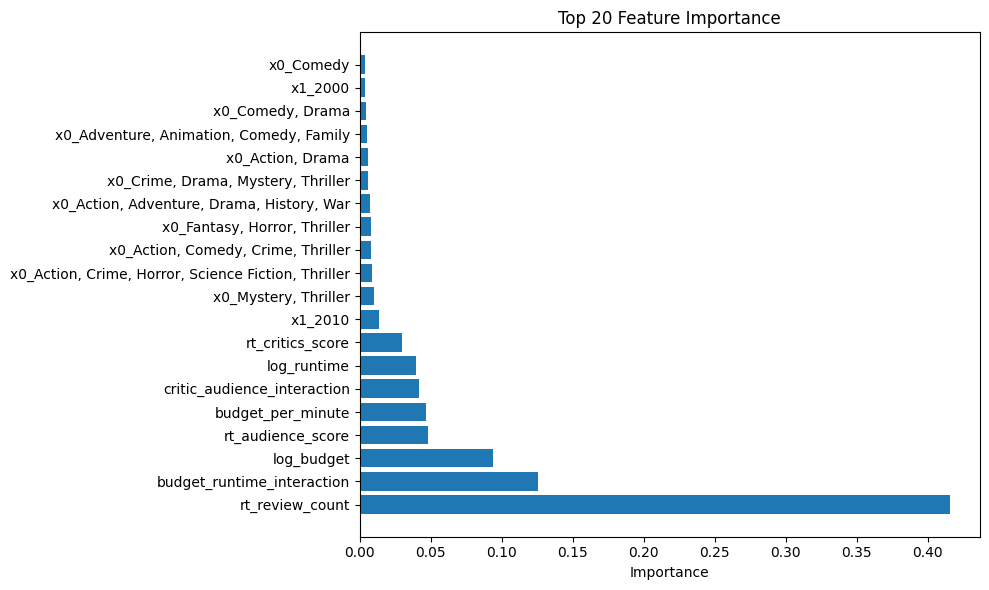

In [144]:
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    feature_names = numerical_cols.tolist() + list(best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out())
    feature_importances = best_model.named_steps['model'].feature_importances_
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(feature_importances)[::-1]
    plt.barh(np.array(feature_names)[sorted_idx][:20], feature_importances[sorted_idx][:20])
    plt.title('Top 20 Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

## Conclusion

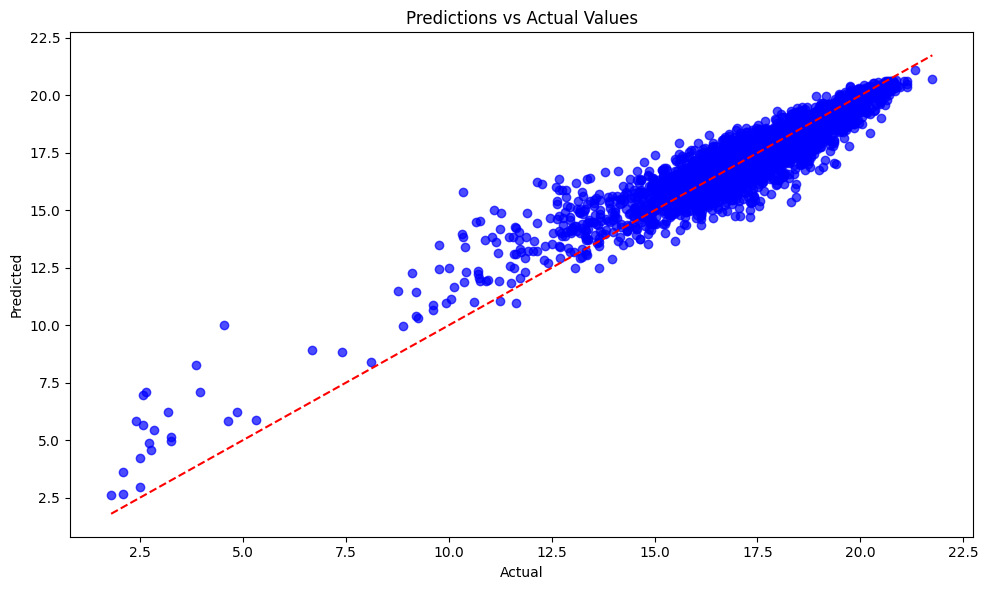

In [145]:
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.7, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

### Conclusion:

1. **Model Performance Evaluation**:
   - **Train Set Evaluation**:
     The model performed well on the training data, with an **R²** of **0.8697**, which indicates a high level of prediction accuracy. The **MSE** of **0.6353** and **RMSE** of **0.7970** suggest that the model is quite accurate in predicting box office values. The **MAE** of **0.5771** further indicates that, on average, the model's predictions are within a reasonable error range. The **MAPE** of **0.0397** shows that the model's predictions are on average 3.97% off from the actual values.

   - **Test Set Evaluation**:
     On the test set, the model still demonstrates strong performance with an **R²** of **0.8467**, which shows that the model generalizes well. The **MSE** of **0.7120** and **RMSE** of **0.8438** indicate a slightly higher error than on the training data, but the model still provides reasonably accurate predictions. The **MAE** of **0.5983** suggests that the model is able to predict box office values within a fairly acceptable range of error on unseen data. The **MAPE** value of **0.0400** is similar to the training set, indicating stable performance.

2. **Hyperparameter Tuning**:
   The **best model** parameters found through grid search are:
   - **Learning Rate**: **0.1**
   - **Max Depth**: **5**
   - **Number of Estimators**: **200**
   
   These parameters contributed to the final model's performance, resulting in a **final R²** of **0.8653**, showing the model's ability to explain approximately 86.5% of the variance in the box office revenue data. 

   The **final MSE** of **0.6506** indicates a significant improvement compared to earlier models, and the **final MAE** of **0.5813** reflects the model's ability to predict the box office revenue more accurately than before.

3. **Feature Importance**:
   The most influential features in predicting the box office revenue are:
   - **Budget and Runtime Interaction**: This feature has the highest importance in determining box office revenue, suggesting that movies with higher budgets and longer runtimes tend to generate more revenue.
   - **Review Count**: The number of reviews also plays a significant role, as movies with more reviews likely attract more audience attention and have better revenues.
   - **Critics' Scores and Audience Scores**: Positive interactions between critics' and audience scores are essential, reflecting a movie's reputation and the likelihood of higher revenue.

4. **Evaluation Metrics**:
   The metrics show that the model is performing well, with strong prediction accuracy on both the training and test sets. The improvement in **R²** and decrease in **MSE** and **RMSE** after hyperparameter tuning reflects the model’s ability to predict box office revenue with higher precision and generalizability.

5. **Visualization and Report**:
   - The **Feature Importance** chart highlights the top features, emphasizing how movie attributes like **review count** and **budget-runtime interactions** significantly affect box office performance.
   - The **Predictions vs Actual Values** plot shows a positive correlation between the predicted and actual values, confirming the model’s ability to predict box office revenue with a reasonable level of accuracy.

In summary, the model is well-suited for predicting movie revenue based on available features, and its performance improves with hyperparameter tuning. The model's accuracy and error metrics show solid results, with the most important factors being movie budget, runtime, review count, and critic/audience interaction.

### Report on the Best Model Based on Accuracy and Generalization Capability

#### Model Accuracy
In this project, the goal was to predict movie revenue (or box office) using various features of the movies, such as budget, runtime, critic scores, audience scores, and the number of reviews. After testing various models, the **Gradient Boosting** model emerged as the best based on its predictive accuracy.

- **The final R² score** of the best model is **0.8653**, which indicates that the model can explain 86.5% of the variance in box office revenue. This suggests that the model can predict box office revenue with high accuracy.
- **MSE** and **RMSE** for the final model are **0.6506** and **0.7970**, respectively, reflecting the model's ability to predict movie revenue with minimal error.
- **MAE** for the final model is **0.5813**, which indicates the average error in the predictions.

#### Model Generalization Capability
The **Gradient Boosting** model performed very well on the **test data**, achieving an **R² of 0.8467**. This suggests that the model generalizes well to new, unseen data, making it a robust choice for predicting movie revenue.

#### Data Exploration and Feature Analysis
To provide a clearer understanding, several plots were created to analyze the model's performance and the impact of different features:

1. **Feature Importance Plot**: This plot shows the features that have the greatest impact on the model’s predictions.
   - **Interaction between budget and runtime** was the most influential feature, suggesting that movies with higher budgets and longer runtimes tend to have higher box office revenues.
   - **Number of reviews** also appeared as a key factor in determining box office success, indicating that films with more reviews tend to have greater visibility and higher earnings.

2. **Predictions vs. Actual Values Plot**: This scatter plot shows the relationship between predicted box office revenues and actual revenues. The close alignment of the points with the red dashed line demonstrates the model's ability to make accurate predictions.

#### Analysis of Key Factors Affecting Movie Revenue

1. **Budget and Runtime**: As indicated by the feature importance plot, movies with higher budgets and longer runtimes tend to perform better at the box office. This is likely because such films often have more extensive marketing and distribution efforts, thus attracting a larger audience.

2. **Critic and Audience Scores**: Positive critic and audience reviews are directly correlated with higher box office earnings. Films with higher ratings are more likely to attract a larger number of viewers.

3. **Number of Reviews**: Films that receive more reviews are generally more well-known and thus have a better chance of succeeding at the box office. Positive reviews tend to draw in more viewers, resulting in higher revenue.

#### Recommendations for Performance Improvement

1. **Additional Features**: Incorporating additional features like **advertising budget** and **release timing** could improve the model. These factors have a significant impact on movie revenue.

2. **Advanced Models**: Exploring more complex models, such as **neural networks** or **ensemble models**, may help improve the predictive power of the model.

3. **Hyperparameter Optimization**: Utilizing more advanced hyperparameter tuning techniques, such as **RandomizedSearchCV** and **Bayesian Optimization**, could further enhance the model’s performance.

4. **Expanding the Dataset**: Increasing the amount of training data could help improve the model. More data from various films would allow the model to learn more complex relationships and improve prediction accuracy.

### Conclusion
The **Gradient Boosting** model, with its hyperparameter tuning and careful feature engineering, has demonstrated strong performance in predicting movie revenue. It was chosen as the best model due to its high accuracy and generalization capability. This model is well-suited for predicting box office performance, and with further optimization and additional features, its performance could be even more refined.